# 1.NSCLC Sex-stratified SC Analysis

## Data selection, pseudobulk, create input for DESEQ2

In [1]:
import warnings
import numpy as np
import pandas as pd 
import scanpy as sc
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#import altair as alt
#import pertpy as pt
#from pandas.api.types import is_categorical_dtype
#from pandas import CategoricalDtype

In [2]:
import decoupler as dc

In [3]:
#Set result directory for figures
resDir = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/figures/"
sc.settings.figdir = resDir

In [4]:
dc.__version__

'1.5.0'

In [5]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp"
input_path    = f"{path}/data/local.h5ad"

In [ ]:
adata = sc.read_h5ad(input_path) 

In [ ]:
adata.obs.dataset.value_counts()

In [ ]:
nsclc_chrom = pd.read_csv(f"{path}/out/007_re_analysis/tables/input/adata_var_nsclc_chrom.csv")

In [ ]:
adata

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
adata.obs.tumor_stage.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.origin.value_counts()

In [ ]:
adata.obs.dataset.value_counts()

### 01.SELECT ONLY male, female & tumor, normal_adjacent

In [ ]:
adata = adata[(adata.obs["disease"] != "normal") & (adata.obs["disease"] != "chronic obstructive pulmonary disease")] #exclude normal and COPD samples

In [ ]:
adata = adata[adata.obs["tumor_stage"].notna()] #exclude samples without tumor stage

In [ ]:
adata = adata[(adata.obs["sex"]=="male")| (adata.obs["sex"]=="female")]

In [ ]:
adata = adata[(adata.obs["origin"]=="tumor_primary")| (adata.obs["origin"]=="normal_adjacent")]

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
adata.obs.tumor_stage.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.origin.value_counts()

In [ ]:
adata.obs.dataset.value_counts()

### 02.CELL TPYE RE-CLASIFICATION 

In [ ]:
adata.obs.cell_type.value_counts()

In [ ]:
adata.obs.cell_type_major.value_counts()

In [ ]:
cells_of_interest=['alveolar macrophage', 'neutrophil','dendritic cell',
 'macrophage','malignant cell',
 'B cell',
  'regulatory T cell',
'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'neutrophils','epithelial cell of lung','multi-ciliated epithelial cell' ]
subset_adata = adata[adata.obs["cell_type"].isin(cells_of_interest)] 


In [ ]:
set(subset_adata.obs.cell_type)

In [ ]:
set(subset_adata.obs.cell_type_major)

In [ ]:
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['alveolar macrophage'], 'macrophage')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD4-positive, alpha-beta T cell'], 'CD4+ T cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD8-positive, alpha-beta T cell'], 'CD8+ T cell')

In [ ]:
set(subset_adata.obs.cell_type)

In [ ]:
subset_adata

In [ ]:
subset_adata.obs.disease.value_counts()

In [ ]:
subset_adata.obs.dataset.value_counts()

In [ ]:
subset_adata.obs.dataset.value_counts()

## PAIRED SAMPLES

In [ ]:
df_grouped = subset_adata.obs.groupby(["origin","donor_id"]).count()

In [ ]:
df_grouped.reset_index(inplace= True)

In [ ]:
df_grouped_normal = df_grouped[df_grouped["origin"]=="normal_adjacent"]

In [ ]:
df_grouped_normal = df_grouped_normal[df_grouped_normal['sample'] != 0]

In [ ]:
df_grouped_tumor = df_grouped[df_grouped["origin"]=="tumor_primary"]

In [ ]:
df_grouped_tumor = df_grouped_tumor[df_grouped_tumor['sample'] != 0]

In [ ]:
df_grouped_tumor

In [ ]:
common_ids =list(set(df_grouped_normal.donor_id)& set(df_grouped_tumor.donor_id))

In [ ]:
len(common_ids)

In [ ]:
paired_adata = subset_adata[subset_adata.obs['donor_id'].isin(common_ids)].copy()

In [ ]:
paired_adata

In [ ]:
df = paired_adata.obs#
origin_counts = df.groupby('origin')['donor_id'].nunique().reset_index()
origin_counts.columns = ['origin', 'count']

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='origin', y='count', palette='viridis')
plt.xlabel('Origin')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per Origin')
plt.show()

In [ ]:
df = paired_adata.obs#
origin_counts = df.groupby('disease')['donor_id'].nunique().reset_index()
origin_counts.columns = ['disease', 'count']

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='disease', y='count', palette='viridis')
plt.xlabel('disease')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per disease')
plt.show()

In [ ]:
paired_adata.obs.disease.value_counts()

In [ ]:
paired_adata.obs.tumor_stage.value_counts()

In [ ]:
paired_adata.obs.sex.value_counts()

In [ ]:
paired_adata.obs.origin.value_counts()

In [ ]:
paired_adata.obs.dataset.value_counts()

In [ ]:
paired_adata

## Create layer Log 1pnorm 

In [ ]:
paired_adata.layers["log1p_norm"] = paired_adata.X.copy()
sc.pp.normalize_total(paired_adata, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(paired_adata, base=6, layer="log1p_norm")

In [ ]:
paired_adata

## Checking for XIST & RPS4Y1 in male and female

In [ ]:
paired_adata.var_names = paired_adata.var.feature_name

In [ ]:
# Now, generate the plot and save it
sc.pl.violin(paired_adata, ["RPS4Y1", "XIST"], use_raw=False, groupby="sex", layer="log1p_norm")#, save="_xy_check.png")

In [ ]:
rps4y1_cells = paired_adata[:, paired_adata.var_names == "RPS4Y1"].X > 0
# Subset the adata object to only those cells
rps4y1_paired_adata_subset = paired_adata[rps4y1_cells, :]

In [ ]:
rps4y1_paired_adata_subset.obs.sex.value_counts()

In [ ]:
xist_cells = paired_adata[:, paired_adata.var_names == "XIST"].X > 0
# Subset the adata object to only those cells
xist_paired_adata_subset = paired_adata[xist_cells, :]

In [ ]:
xist_paired_adata_subset.obs.sex.value_counts()

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
rps4y1_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()

In [ ]:
xist_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()

These patients express X and Y realted chromosomes oposite to what they are labelled. 

* rps4y1 "Lambrechts_Thienpont_2018_6653_8", "Leader_Merad_2021_406"
* xist "Lambrechts_Thienpont_2018_6653_6", "Leader_Merad_2021_581"
- Relabel as oposite (male & female) 

## Relabel sex for these donor id 

In [ ]:
set(paired_adata.obs[paired_adata.obs["donor_id"]=="Leader_Merad_2021_581"].sex)

In [ ]:
# Define the donor_ids for which you want to replace 'female' by 'male'
donor_ids_ftom = ['Lambrechts_Thienpont_2018_6653_8', 'Leader_Merad_2021_406']
donor_ids_mtof = ['Lambrechts_Thienpont_2018_6653_6','Leader_Merad_2021_581']

# Replace 'female' by 'male' in the 'sex' column for specific donor_ids
paired_adata.obs.loc[paired_adata.obs['donor_id'].isin(donor_ids_ftom) & (paired_adata.obs['sex'] == 'female'), 'sex'] = 'male'
paired_adata.obs.loc[paired_adata.obs['donor_id'].isin(donor_ids_mtof) & (paired_adata.obs['sex'] == 'male'), 'sex'] = 'female'

In [ ]:
#paired_adata_clean = paired_adata[~paired_adata.obs["donor_id"].isin(["Lambrechts_Thienpont_2018_6653_8", "Leader_Merad_2021_406", "Lambrechts_Thienpont_2018_6653_6", "Leader_Merad_2021_581"])]

In [ ]:
paired_adata

In [ ]:
rps4y1_cells = paired_adata[:, paired_adata.var_names == "RPS4Y1"].X > 0

# Subset the adata object to only those cells
rps4y1_paired_adata_subset = paired_adata[rps4y1_cells, :]

In [ ]:
rps4y1_paired_adata_subset.obs.sex.value_counts()

In [ ]:
xist_cells = paired_adata[:, paired_adata.var_names == "XIST"].X > 0

# Subset the adata object to only those cells
xist_paired_adata_subset = paired_adata[xist_cells, :]

In [ ]:
xist_paired_adata_subset.obs.sex.value_counts()

In [ ]:
rps4y1_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()

In [ ]:
xist_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()

In [ ]:
# Now, generate the plot and save it
sc.pl.violin(paired_adata, ["RPS4Y1", "XIST"], use_raw=False, groupby="sex", layer="log1p_norm", save="_xy_check.png")

## Check X and Y chromosome related genes

In [ ]:
x_genes =  ["XIST","TSIX"]
y_genes = ["RPS4Y1","RPS4Y2","ZFY","UTY"]

In [ ]:
sc.pl.violin(paired_adata, x_genes, use_raw=False, groupby="sex", layer="log1p_norm")

In [ ]:
sc.pl.violin(paired_adata, y_genes, use_raw=False, groupby="sex", layer="log1p_norm", save="violin_y.png")

In [ ]:
paired_adata.var.index.name = None

In [ ]:
#paired_adata.write_h5ad("/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/paired_adata_clean.h5ad")

In [6]:
paired_adata = sc.read_h5ad("/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/paired_adata_clean.h5ad")

In [7]:
paired_adata

AnnData object with n_obs × n_vars = 466234 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

## SUMMARY 
- We used the sex annotation that was given in the respective datasets
- These annotations were confirmed by our analysis, as no Ygenes were in the female cohort. 

### 04.Compute pseudobulk

In [8]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/"

In [ ]:
# Get pseudo-bulk profile
#pdata = dc.get_pseudobulk(
#    paired_adata,
#    sample_col='sample',
#    groups_col='donor_id',
#    layer='count',
#    min_cells=0,
#    min_counts=0
#)

In [9]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    paired_adata,
    sample_col="sample",
    groups_col=["cell_type","origin"],
    layer="count",  # layer where raw counts are store in adata
    mode="sum",
    min_cells=0,  # we are setting this to 0 and filter in an explicit, separate step.
    min_counts=0,
)
pdata

/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/decoupler/utils_anndata.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cols = obs.groupby([sample_col, groups_col]).apply(lambda x: x.apply(lambda y: len(y.unique()) == 1)).all(0)
/home/kvalem/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 1666 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'ann_coarse', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_type_origin', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

In [10]:
pdata.layers["counts"] = pdata.X

In [11]:
scales_counts = sc.pp.normalize_total(pdata, target_sum=None, inplace=False)
# log1p transform
pdata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [12]:
pdata.obs["age"] = pdata.obs["age"].astype("float64")
pdata.obs["is_primary_data"] = pdata.obs["is_primary_data"].astype(bool)

In [13]:
path

'/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/'

In [14]:
pdata.write_h5ad(f"{path}/pdata_cell_type.h5ad")

In [ ]:
#pdata = sc.read_h5ad(f"{path}/out/008_analysis_paired_luad/tables/input/pdata.h5ad")

In [15]:
pdata.obs

,sample,uicc_stage,ever_smoker,age,donor_id,origin,dataset,doublet_status,ann_coarse,tumor_stage,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,cell_type_origin,psbulk_n_cells,psbulk_counts
Goveia_Carmeliet_2020_patient_41_normal_adjacent_B cell_normal_adjacent,Goveia_Carmeliet_2020_patient_41_normal_adjacent,II,yes,69.0,Goveia_Carmeliet_2020_patient_41,normal_adjacent,Goveia_Carmeliet_2020,singlet,B cell,early,...,10x 3' v2,squamous cell lung carcinoma,Homo sapiens,male,lung,unknown,69-year-old human stage,B cell_normal_adjacent,1.0,1764.0
Goveia_Carmeliet_2020_patient_42_normal_adjacent_B cell_normal_adjacent,Goveia_Carmeliet_2020_patient_42_normal_adjacent,II,yes,74.0,Goveia_Carmeliet_2020_patient_42,normal_adjacent,Goveia_Carmeliet_2020,singlet,B cell,early,...,10x 3' v2,squamous cell lung carcinoma,Homo sapiens,male,lung,unknown,74-year-old human stage,B cell_normal_adjacent,29.0,80625.0
He_Fan_2021_N1_B cell_normal_adjacent,He_Fan_2021_N1,I,no,48.0,He_Fan_2021_P1,normal_adjacent,He_Fan_2021,singlet,B cell,early,...,10x 3' v2,lung adenocarcinoma,Homo sapiens,female,lung,unknown,48-year-old human stage,B cell_normal_adjacent,75.0,102672.0
He_Fan_2021_N2_B cell_normal_adjacent,He_Fan_2021_N2,II,yes,61.0,He_Fan_2021_P2,normal_adjacent,He_Fan_2021,singlet,B cell,early,...,10x 3' v2,lung adenocarcinoma,Homo sapiens,male,lung,unknown,61-year-old human stage,B cell_normal_adjacent,11.0,18468.0
He_Fan_2021_N3_B cell_normal_adjacent,He_Fan_2021_N3,I,yes,58.0,He_Fan_2021_P3,normal_adjacent,He_Fan_2021,singlet,B cell,early,...,10x 3' v2,lung adenocarcinoma,Homo sapiens,female,lung,unknown,58-year-old human stage,B cell_normal_adjacent,21.0,26543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKIM-V-2_P8_tumor_primary_regulatory T cell_tumor_primary,UKIM-V-2_P8_tumor_primary,I,yes,67.0,UKIM-V-2_P8,tumor_primary,UKIM-V-2,singlet,T cell,early,...,BD Rhapsody Whole Transcriptome Analysis,squamous cell lung carcinoma,Homo sapiens,male,lung,unknown,67-year-old human stage,regulatory T cell_tumor_primary,46.0,168032.0
UKIM-V-2_P9_tumor_primary_regulatory T cell_tumor_primary,UKIM-V-2_P9_tumor_primary,I,yes,69.0,UKIM-V-2_P9,tumor_primary,UKIM-V-2,singlet,T cell,early,...,BD Rhapsody Whole Transcriptome Analysis,lung adenocarcinoma,Homo sapiens,male,lung,unknown,69-year-old human stage,regulatory T cell_tumor_primary,629.0,1196851.0
UKIM-V_P1_tumor_primary_regulatory T cell_tumor_primary,UKIM-V_P1_tumor_primary,I,yes,65.0,UKIM-V_P1,tumor_primary,UKIM-V,singlet,T cell,early,...,BD Rhapsody Whole Transcriptome Analysis,lung adenocarcinoma,Homo sapiens,female,lung,unknown,65-year-old human stage,regulatory T cell_tumor_primary,33.0,449844.0
UKIM-V_P2_tumor_primary_regulatory T cell_tumor_primary,UKIM-V_P2_tumor_primary,I,yes,70.0,UKIM-V_P2,tumor_primary,UKIM-V,singlet,T cell,early,...,BD Rhapsody Whole Transcriptome Analysis,squamous cell lung carcinoma,Homo sapiens,female,lung,unknown,70-year-old human stage,regulatory T cell_tumor_primary,213.0,1875806.0


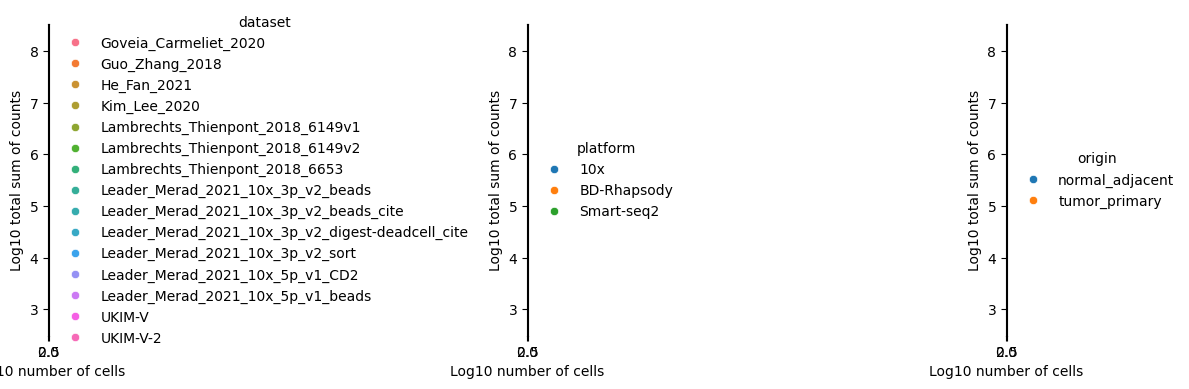

In [16]:
dc.plot_psbulk_samples(pdata, groupby=['dataset', 'platform',"origin"], figsize=(12, 4))

In [17]:
cell_types = pdata.obs["cell_type"].unique()

In [18]:
cell_types

['B cell', 'CD4+ T cell', 'CD8+ T cell', 'dendritic cell', 'epithelial cell', 'macrophage', 'malignant cell', 'neutrophil', 'regulatory T cell']
Categories (9, object): ['B cell', 'CD4+ T cell', 'CD8+ T cell', 'dendritic cell', ..., 'macrophage', 'malignant cell', 'neutrophil', 'regulatory T cell']

In [19]:
pdata_by_cell_type = {}
for ct in cell_types:
    pb = pdata[pdata.obs["cell_type"] == ct, :].copy()
    if pb.obs["origin"].nunique() <= 1:
        print(f"Cell type {ct} does not have samples in all groups")
    else:
        pdata_by_cell_type[ct] = pb

In [20]:
pdata_by_cell_type

{'B cell': AnnData object with n_obs × n_vars = 186 × 17811
     obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'ann_coarse', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_type_origin', 'psbulk_n_cells', 'psbulk_counts'
     var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
     layers: 'psbulk_props', 'counts'

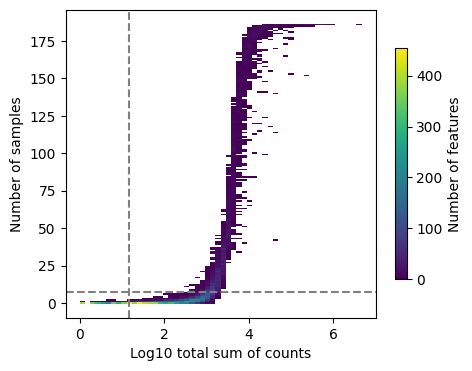

In [21]:
dc.plot_filter_by_expr(
    pdata_by_cell_type['B cell'],
    group="origin",
    min_count=10,
    min_total_count=15,
)

In [22]:
for tmp_pdata in pdata_by_cell_type.values():
    dc.filter_by_expr(
        tmp_pdata,
        group="origin",
        min_count=10,
        min_total_count=15,
    )

In [23]:
from pathlib import Path
import re


In [24]:
deseq_results = Path("/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/deseq2_out/pb_cell_type")

In [25]:
def _create_prefix(cell_type):
    ct_sanitized = re.sub("[^0-9a-zA-Z]+", "_", cell_type)
    prefix = deseq_results / "tumor_vs_normal" / ct_sanitized
    prefix.mkdir(parents=True, exist_ok=True)
    return prefix

In [26]:
for ct, tmp_pdata in pdata_by_cell_type.items():
    prefix = _create_prefix(ct)
    print(prefix)

/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/deseq2_out/pb_cell_type/tumor_vs_normal/B_cell
/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/deseq2_out/pb_cell_type/tumor_vs_normal/CD4_T_cell
/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/deseq2_out/pb_cell_type/tumor_vs_normal/CD8_T_cell
/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/deseq2_out/pb_cell_type/tumor_vs_normal/dendritic_cell
/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/deseq2_out/pb_cell_type/tumor_vs_normal/epithelial_cell
/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/deseq2_out/pb_cell_type/tumor_vs_normal/macrophage
/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/deseq2_out/pb_cell_type/tumor_vs_normal/malignant_cell
/data/projects/2023/LCBiome/nsclc_gende

In [29]:
### Samplesheet
for ct, tmp_pdata in pdata_by_cell_type.items():
    prefix = _create_prefix(ct)
    ct_sanitized = re.sub("[^0-9a-zA-Z]+", "_", ct)

#for index, dataframe in enumerate(pdata_list):
    
    # Perform the operations
    samplesheet = tmp_pdata.obs.copy()
    samplesheet["sample"] = samplesheet.index
    samplesheet.reset_index(inplace=True)
  
    samplesheet.to_csv(f"{prefix}/samplesheet_{ct_sanitized}.csv", index=False)
    samplesheet.to_csv(f"{prefix}/samplesheet_{ct_sanitized}.tsv", index=False, sep="\t")


    ### Raw counts
    bulk_df = tmp_pdata.to_df().T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{prefix}/counts_{ct_sanitized}.csv")  
    ### log1p_norm counts
    pdata_log1p_norm = pd.DataFrame(tmp_pdata.layers["log1p_norm"], 
        tmp_pdata.to_df().index, 
        tmp_pdata.to_df().columns)
    bulk_df = pdata_log1p_norm.T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{prefix}/log1p_norm_counts_{ct_sanitized}.csv")    

In [30]:
### Samplesheet
for ct, tmp_pdata in pdata_by_cell_type.items():
    prefix = _create_prefix(ct)
    ct_sanitized = re.sub("[^0-9a-zA-Z]+", "_", ct)

#for index, dataframe in enumerate(pdata_list):
    
    # Perform the operations
    tmp_pdata_female = tmp_pdata[tmp_pdata.obs["sex"]=="female"]
    samplesheet = tmp_pdata_female.obs.copy()
    samplesheet["sample"] = samplesheet.index
    samplesheet.reset_index(inplace=True)
  
    samplesheet.to_csv(f"{prefix}/samplesheet_female_{ct_sanitized}.csv", index=False)
    samplesheet.to_csv(f"{prefix}/samplesheet_female_{ct_sanitized}.tsv", index=False, sep="\t")


    ### Raw counts
    bulk_df = tmp_pdata_female.to_df().T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{prefix}/counts_female_{ct_sanitized}.csv")  
    ### log1p_norm counts
    pdata_log1p_norm = pd.DataFrame(tmp_pdata_female.layers["log1p_norm"], 
        tmp_pdata_female.to_df().index, 
        tmp_pdata_female.to_df().columns)
    bulk_df = pdata_log1p_norm.T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{prefix}/log1p_norm_counts_female_{ct_sanitized}.csv")    

In [32]:
### Samplesheet
for ct, tmp_pdata in pdata_by_cell_type.items():
    prefix = _create_prefix(ct)
    ct_sanitized = re.sub("[^0-9a-zA-Z]+", "_", ct)

#for index, dataframe in enumerate(pdata_list):
    
    # Perform the operations
    tmp_pdata_male = tmp_pdata[tmp_pdata.obs["sex"]=="male"]
    samplesheet = tmp_pdata_male.obs.copy()
    samplesheet["sample"] = samplesheet.index
    samplesheet.reset_index(inplace=True)
  
    samplesheet.to_csv(f"{prefix}/samplesheet_male_{ct_sanitized}.csv", index=False)
    samplesheet.to_csv(f"{prefix}/samplesheet_male_{ct_sanitized}.tsv", index=False, sep="\t")


    ### Raw counts
    bulk_df = tmp_pdata_male.to_df().T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{prefix}/counts_male_{ct_sanitized}.csv")  
    ### log1p_norm counts
    pdata_log1p_norm = pd.DataFrame(tmp_pdata_male.layers["log1p_norm"], 
        tmp_pdata_male.to_df().index, 
        tmp_pdata_male.to_df().columns)
    bulk_df = pdata_log1p_norm.T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{prefix}/log1p_norm_counts_male_{ct_sanitized}.csv")    

In [ ]:
#pdata = pdata[pdata.obs["dataset"]!="Guo_Zhang_2018"] ## SMART SEQ 

In [ ]:
#pdata

In [ ]:
#dc.plot_psbulk_samples(pdata, groupby=['dataset', 'platform'], figsize=(12, 4))

In [ ]:
dc.plot_filter_by_expr(
    pdata_by_cell_type["Epithelial cell"],
    group="condition",
    min_count=10,
    min_total_count=15,
)

In [ ]:
dc.plot_filter_by_expr(pdata, group='sample', min_count=10, min_total_count=15)

In [ ]:
dc.plot_filter_by_expr(pdata, group='sample', large_n=100,min_prop=0.9, min_count=5000, min_total_count=10000)

I set this threshold for the DS analysis to avoid havinh zero-inflated data

In [ ]:
# Obtain genes that pass the thresholds 
genes = dc.filter_by_expr(pdata, group='sample', min_count=5000, min_total_count=10000)

# Filter by these genes
pdata = pdata[:, genes].copy()
pdata

In [ ]:
pdata.layers["counts"] = pdata.X

In [ ]:
scales_counts = sc.pp.normalize_total(pdata, target_sum=None, inplace=False)
# log1p transform
pdata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [ ]:
pdata

In [ ]:
pdata.write_h5ad("/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/pdata.h5ad")

In [ ]:
### Samplesheet
samplesheet = pdata.obs.copy()
samplesheet["sample"]=samplesheet.index
samplesheet.reset_index(inplace=True)

In [ ]:
samplesheet.to_csv(f"{path}samplesheet.csv", index=False)
samplesheet.to_csv(f"{path}samplesheet.tsv", index=False, sep = "\t")

In [ ]:
bulk_df = pdata.to_df().T

In [ ]:
### Raw counts
bulk_df = pdata.to_df().T
#bulk_df["gene_id"]=bulk_df.index
bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")

In [ ]:
bulk_df.to_csv(f"{path}counts.csv")    

In [ ]:
### log1p_norm counts
pdata_log1p_norm = pd.DataFrame(pdata.layers["log1p_norm"], 
    pdata.to_df().index, 
    pdata.to_df().columns)
bulk_df = pdata_log1p_norm.T
#bulk_df["gene_id"]=bulk_df.index'
bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
bulk_df.to_csv(f"{path}log1p_norm_counts.csv")    

### 0.4 Create counts and samplesheet independent for tumor and normal for DESEQ2 

In [ ]:
pdata_normal = pdata[pdata.obs["origin"]=="normal_adjacent"]
pdata_tumor = pdata[pdata.obs["origin"]=="tumor_primary"]

In [ ]:
pdata_normal

In [ ]:
pdata_list = [pdata_normal,pdata_tumor]
pdata_list_name = ["normal","tumor"]

for index, dataframe in enumerate(pdata_list):
    print(pdata_list_name[index])
    # Perform the operations
    samplesheet = dataframe.obs.copy()
    samplesheet["sample"] = samplesheet.index
    samplesheet.reset_index(inplace=True)
  
    samplesheet.to_csv(f"{path}samplesheet_{pdata_list_name[index]}.csv", index=False)
    samplesheet.to_csv(f"{path}samplesheet_{pdata_list_name[index]}.tsv", index=False, sep="\t")


    ### Raw counts
    bulk_df = dataframe.to_df().T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}counts_{pdata_list_name[index]}.csv")  
    ### log1p_norm counts
    pdata_log1p_norm = pd.DataFrame(dataframe.layers["log1p_norm"], 
        dataframe.to_df().index, 
        dataframe.to_df().columns)
    bulk_df = pdata_log1p_norm.T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}/log1p_norm_counts_{pdata_list_name[index]}.csv")    

### 0.4 Create counts and samplesheet independent for male and female for DESEQ2 

In [ ]:
pdata_male = pdata[pdata.obs["sex"]=="male"]
pdata_female = pdata[pdata.obs["sex"]=="female"]

In [ ]:
pdata_male

In [ ]:
pdata_list = [pdata_male,pdata_female]
pdata_list_name = ["male","female"]

for index, dataframe in enumerate(pdata_list):
    print(pdata_list_name[index])
    # Perform the operations
    samplesheet = dataframe.obs.copy()
    samplesheet["sample"] = samplesheet.index
    samplesheet.reset_index(inplace=True)
  
    samplesheet.to_csv(f"{path}samplesheet_{pdata_list_name[index]}.csv", index=False)
    samplesheet.to_csv(f"{path}samplesheet_{pdata_list_name[index]}.tsv", index=False, sep="\t")


    ### Raw counts
    bulk_df = dataframe.to_df().T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}counts_{pdata_list_name[index]}.csv")  
    ### log1p_norm counts
    pdata_log1p_norm = pd.DataFrame(dataframe.layers["log1p_norm"], 
        dataframe.to_df().index, 
        dataframe.to_df().columns)
    bulk_df = pdata_log1p_norm.T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}/log1p_norm_counts_{pdata_list_name[index]}.csv")    